In [166]:
import numpy as np
import matplotlib.pyplot as plt
import torch  as th
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle
import pandas as pd
import seaborn as sns
import random
import os
import glob
import numpy as np
import gzip as gz
import pickle
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader, random_split
from BESTRq_classes.BESTRq import BestRqFramework, RandomProjectionQuantizer
from compute_fft import compute_spectrogram, plot_spectrogram, mask_and_replace
from models.CNN_BiLSTM_Attention import ParallelModel

In [167]:
###### Set the device to use Apple M1 GPU #######
device_GPU = th.device('mps')

# GAN implementation : comparison between spectrum and time serie 
https://towardsdatascience.com/synthetic-time-series-data-a-gan-approach-869a984f2239

In [168]:
data_path = '/Users/martinblot/Desktop/sleep-edf-prepared/5-cassette'  ## path towards the 5-cassette file
fp = gz.open(data_path+'/SC4001E0.npz.gz','rb')
data_test = np.load(fp,allow_pickle=True)
fnames = glob.glob(os.path.join(data_path, "*npz.gz"))
devpart = 10
xtrain , xvalid = None , None
ytrain , yvalid = None , None
measurement=data_test['ch_label'][2]

for fn in tqdm(fnames):
    fp = gz.open(fn,'rb')
    data = np.load(fp,allow_pickle=False) # for now, don't care about headers
    x = data['x'][:,:,2] # EEG and EOG
    y = data['y'] # Take the labels
    idx = np.arange(x.shape[0])
    np.random.shuffle(idx)
    devlim = x.shape[0]//devpart
    devpart = 10
    idx = np.arange(x.shape[0])
    np.random.shuffle(idx)
    devlim = x.shape[0]//devpart
    if xtrain is None:
        xtrain = np.zeros((1,x.shape[1]))    ##np.zeros((1,x.shape[1],2)) if we include EOG  
        xvalid = np.zeros((1,x.shape[1]))
        ytrain , yvalid = np.zeros(1) , np.zeros(1)
    xvalid = np.concatenate((xvalid,x[idx[:devlim]]), axis=0)
    yvalid = np.concatenate((yvalid,y[idx[:devlim]]), axis=0)
    xtrain = np.concatenate((xtrain,x[idx[devlim:]]), axis=0)
    ytrain = np.concatenate((ytrain,y[idx[devlim:]]), axis=0)
    del x,y

xtrain , xvalid = xtrain[1:] , xvalid[1:]
ytrain , yvalid = ytrain[1:] , yvalid[1:]
xtrain, xvalid = th.FloatTensor(xtrain), th.FloatTensor(xvalid)
ytrain, yvalid = th.IntTensor(ytrain), th.IntTensor(yvalid)

100%|██████████| 153/153 [01:01<00:00,  2.47it/s]


In [170]:
outf="/Users/martinblot/Desktop/sleep-edf-prepared/cassette-th-data-all.pck"
fp = open(outf,"wb")
pickle.dump((xtrain , xvalid , ytrain , yvalid), fp)
filepath = '/Users/martinblot/Desktop/sleep-edf-prepared/cassette-th-data-all.pck'
xtrain,xvalid, ytrain, yvalid = np.load(filepath, allow_pickle = True)
print(xtrain.shape)

torch.Size([175995, 600])


In [244]:
batch=1000
N=10000

label_mask=np.zeros_like(ytrain[:N])
label_mask[0:100]=1
label_mask_tensor=th.tensor(label_mask)
xtrain_tensor,ytrain_tensor=th.tensor(xtrain[:N]),th.tensor(ytrain[:N])
xvalid_tensor,yvalid_tensor=th.tensor(xvalid[:N//2]),th.tensor(yvalid[:N//2])

dataset_t = TensorDataset(xtrain_tensor, ytrain_tensor, label_mask_tensor)
train_loader = DataLoader(dataset_t, batch_size= batch, shuffle=True)
dataset_v = TensorDataset(xvalid_tensor, yvalid_tensor)
valid_loader = DataLoader(dataset_v, batch_size= batch, shuffle=True)

/var/folders/4d/0mw5kdt55tl7r35rc_2wqkph0000gn/T/ipykernel_53208/3565093093.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xtrain_tensor,ytrain_tensor=th.tensor(xtrain[:N]),th.tensor(ytrain[:N])
/var/folders/4d/0mw5kdt55tl7r35rc_2wqkph0000gn/T/ipykernel_53208/3565093093.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xvalid_tensor,yvalid_tensor=th.tensor(xvalid[:N//2]),th.tensor(yvalid[:N//2])


In [245]:
class Generator(nn.Module):
    def __init__(self, hidden_dim, output_dim, n_layers):
        super(Generator, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.output_dim= output_dim
        # Couches du générateur
        self.GRU = nn.GRU(1, hidden_dim, num_layers=n_layers, batch_first=True, bidirectional=True)
        self.gen_block = nn.Linear(2*hidden_dim, output_dim)
        self.activation = nn.Sigmoid()
    
    def forward(self, x):
        x=x.unsqueeze(-1)
        # Passage des données par le GRU
        x, _ = self.GRU(x)
        # Prendre seulement la sortie du dernier pas de temps
        x = x[:, -1]
        # Application de la couche linéaire
        x = self.gen_block(x)
        # Activation
        x = self.activation(x)
        return x
    
class Discriminator(nn.Module):
    def __init__(self, hidden_dim, n_layers, num_classes):
        super(Discriminator, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.num_classes = num_classes
        # Couches du discriminateur
        self.GRU = nn.GRU(1, hidden_dim, num_layers=n_layers, batch_first=True, bidirectional=True)
        self.dis_block = nn.Linear(2 * hidden_dim, 1)
        self.activation = nn.Sigmoid()
        # Couches supplémentaires pour les sorties supplémentaires
        self.class_block = nn.Linear(2 * hidden_dim, num_classes)
    
    def forward(self, x):
        x = x.unsqueeze(-1)
        # Passage des données par le GRU
        x, _ = self.GRU(x)
        # Prendre seulement la sortie du dernier pas de temps
        x = x[:, -1]
        # Application de la couche linéaire pour la sortie discriminante
        dis_output = self.dis_block(x)
        # Activation
        dis_output = self.activation(dis_output)
        # Ajouter les couches supplémentaires pour les sorties supplémentaires
        # Calcul des logits de classification
        class_logits = self.class_block(x)
        # Calcul des logits GAN
        gan_logits = th.logsumexp(class_logits, 1)
        # Calcul des caractéristiques extraites
        features = x  # Utilisation de la sortie avant la dernière couche linéaire
        # Retourner toutes les sorties
        return dis_output, class_logits, gan_logits, features


In [246]:
def compute_loss(fake_output, fake_labels, real_output, real_batch_labels, gen_criterion, dis_criterion, class_logits, labels, label_mask_tensor, supervised_criterion=nn.CrossEntropyLoss()):
    gloss = gen_criterion(fake_output, real_batch_labels)
    unsupervised_loss = dis_criterion(real_output, real_batch_labels)+dis_criterion(fake_output, fake_labels)
    supervised_loss = supervised_criterion(class_logits, labels.long())    
    label_mask=th.squeeze(label_mask_tensor)
    supervised_loss = th.sum(th.mul(supervised_loss, label_mask))
    supervised_loss = supervised_loss / th.max(th.tensor(1.0), th.sum(label_mask))
    dloss=supervised_loss+unsupervised_loss
    # Calculate accuracy
    correct, masked_correct = 0,0
    
    # These lines are equivalent to the TensorFlow code `eq = tf.equal(tf.squeeze(y), pred_class)`
    eq = th.eq(th.squeeze(labels), th.argmax(class_logits, dim=1))
    
    # This part computes the number of correct predictions considering only the labeled data
    masked_correct = th.sum(label_mask * eq.float()).item()
    
    # This part computes the number of correct predictions considering all data, both labeled and unlabeled
    correct = th.sum(eq.float()).item()
    
    return gloss,dloss,correct,masked_correct


https://github.com/ydataai/ydata-synthetic/blob/dev/src/ydata_synthetic/synthesizers/timeseries/timegan/model.py

In [247]:
def train_GAN(discriminator, generator, batch, trainloader, validloader, hidden_dim, dis_loss, gen_loss, input_dim=600, lr=0.0002, nepoch=10, device='cpu'):
    real_batch_labels = th.ones((batch, 1)).to(device)
    fake_batch_labels = th.zeros((batch, 1)).to(device)
    optim_generator = optim.Adam(generator.parameters(), lr=lr)
    optim_discriminator = optim.Adam(discriminator.parameters(), lr=lr)
    g_losses, d_losses, train_accuracies, val_accuracies= [], [], [], []
    for epoch in tqdm(range(nepoch)):
        running_d_loss = 0
        running_g_loss = 0
        train_correct = 0
        val_correct = 0
        total_samples = 0  # Total number of samples, including both labeled and unlabeled
        total_samples_val=0
        for inputs, labels, labels_mask in trainloader:
            z = th.randn((batch, hidden_dim))
            h = generator(z)
            fake_outputs, _, _, _ = discriminator(h)
            outputs, class_logits, _, _ = discriminator(inputs)
            outputs, class_logits = outputs.to(device), class_logits.to(device)
            g_loss, d_loss, _ , masked_correct = compute_loss(fake_outputs, fake_batch_labels, outputs, real_batch_labels, gen_loss, dis_loss, class_logits, labels, labels_mask)
            optim_discriminator.zero_grad()
            optim_generator.zero_grad()
            d_loss.backward(retain_graph=True)
            g_loss.backward()
            optim_discriminator.step()
            optim_generator.step()

            running_d_loss += d_loss.item()
            running_g_loss += g_loss.item()
            train_correct += masked_correct
            total_samples += labels.size(0)  # Add the number of samples in the current batch to the total

        g_losses.append(running_g_loss / len(trainloader))
        d_losses.append(running_d_loss / len(trainloader))
        train_accuracy = train_correct / total_samples  # Calculate accuracy by dividing the total correct predictions by the total samples
        train_accuracies.append(train_accuracy)

        for inputs_val, labels_val in validloader:
            z = th.randn((batch, hidden_dim))
            h = generator(z)
            fake_outputs, _, _, _ = discriminator(h)
            outputs, class_logits, _, _ = discriminator(inputs_val)
            _,_,correct,_  = compute_loss(fake_outputs, fake_batch_labels, outputs, real_batch_labels, gen_loss, dis_loss, class_logits, labels, labels_mask)
            optim_discriminator.zero_grad()
            optim_generator.zero_grad()
            optim_discriminator.step()
            optim_generator.step()

            val_correct+=correct
            total_samples_val += labels_val.size(0)

        val_accuracy=val_correct / total_samples_val
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch + 1}/{nepoch} -> "
              f"Generator Loss: {running_g_loss:.4f}, "
              f"Discriminator Loss: {running_d_loss:.4f}, "
              f"Training accuracy : {train_accuracy:.4f}, "
              f"Validation accuracy : {val_accuracy:.4f}")

    return g_losses, d_losses, train_accuracies, val_accuracies


In [248]:
learning_rate=0.001
hidden_dim = 32
num_epochs = 10
input_dim=600
n_layers=2

# Instanciation des modèles
generator = Generator(hidden_dim, input_dim, n_layers)
discriminator = Discriminator(hidden_dim,n_layers,5)

bceloss=nn.BCELoss()

g_losses, d_losses, train_accuracies, val_accuracies=train_GAN(discriminator, generator, batch, train_loader, valid_loader, hidden_dim, bceloss, bceloss, lr = 0.0002, nepoch = num_epochs)

 10%|█         | 1/10 [06:36<59:28, 396.46s/it]

Epoch 1/10 -> Generator Loss: 6.6758, Discriminator Loss: 29.8697, Training accuracy : 0.0033, Validation accuracy : 0.1922


 20%|██        | 2/10 [13:57<56:21, 422.66s/it]

Epoch 2/10 -> Generator Loss: 6.5362, Discriminator Loss: 29.1733, Training accuracy : 0.0036, Validation accuracy : 0.2686


 30%|███       | 3/10 [21:28<50:49, 435.59s/it]

Epoch 3/10 -> Generator Loss: 6.4108, Discriminator Loss: 28.5549, Training accuracy : 0.0041, Validation accuracy : 0.3248


 40%|████      | 4/10 [28:03<41:56, 419.40s/it]

Epoch 4/10 -> Generator Loss: 6.2972, Discriminator Loss: 28.0050, Training accuracy : 0.0044, Validation accuracy : 0.3206


 50%|█████     | 5/10 [34:42<34:20, 412.10s/it]

Epoch 5/10 -> Generator Loss: 6.1931, Discriminator Loss: 27.4912, Training accuracy : 0.0046, Validation accuracy : 0.3086


 60%|██████    | 6/10 [42:32<28:46, 431.74s/it]

Epoch 6/10 -> Generator Loss: 6.1009, Discriminator Loss: 27.0041, Training accuracy : 0.0046, Validation accuracy : 0.3228


 70%|███████   | 7/10 [48:49<20:41, 413.88s/it]

Epoch 7/10 -> Generator Loss: 6.0207, Discriminator Loss: 26.5294, Training accuracy : 0.0046, Validation accuracy : 0.3404


 80%|████████  | 8/10 [55:34<13:42, 411.26s/it]

Epoch 8/10 -> Generator Loss: 5.9561, Discriminator Loss: 26.0645, Training accuracy : 0.0047, Validation accuracy : 0.3406


 90%|█████████ | 9/10 [1:03:14<07:06, 426.38s/it]

Epoch 9/10 -> Generator Loss: 5.9108, Discriminator Loss: 25.5988, Training accuracy : 0.0047, Validation accuracy : 0.3456


100%|██████████| 10/10 [1:10:11<00:00, 421.17s/it]

Epoch 10/10 -> Generator Loss: 5.8946, Discriminator Loss: 25.1285, Training accuracy : 0.0046, Validation accuracy : 0.3506


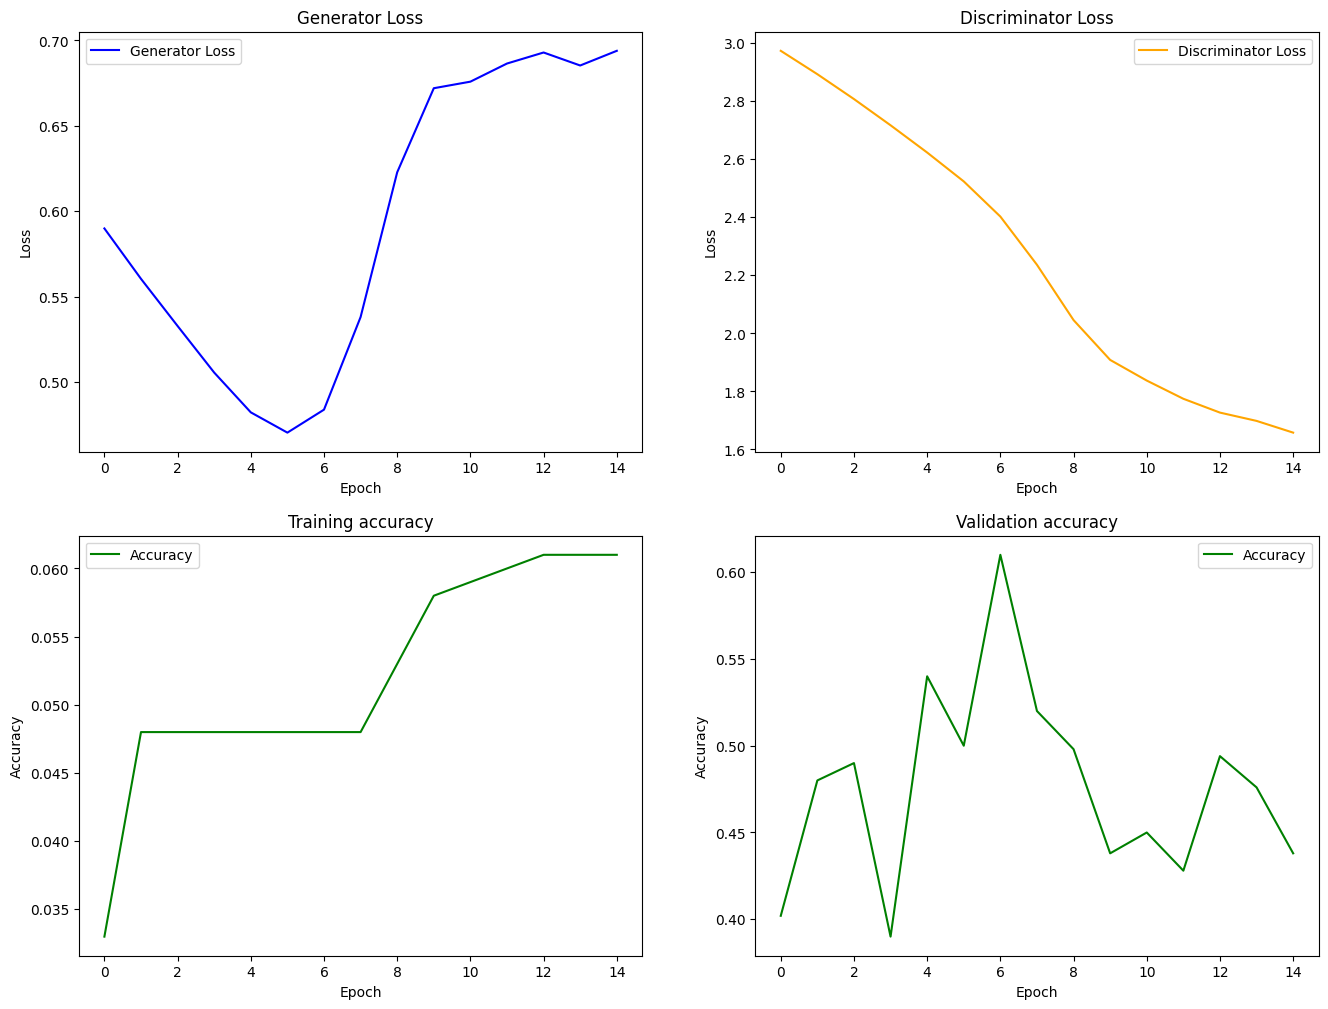

In [233]:
# Plot loss curves
plt.figure(figsize=(16, 12))

# Generator Loss subplot
plt.subplot(2, 2, 1)
plt.plot(g_losses, label='Generator Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Generator Loss')
plt.legend()

# Discriminator Loss subplot
plt.subplot(2, 2, 2)
plt.plot(d_losses, label='Discriminator Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Discriminator Loss')
plt.legend()

# Accuracy subplot
plt.subplot(2, 2, 3)
plt.plot(train_accuracies, label='Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training accuracy')
plt.legend()

# Accuracy subplot
plt.subplot(2, 2, 4)
plt.plot(val_accuracies, label='Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation accuracy')
plt.legend()
plt.show()
